# Patchwork builder ussage example
Using data from `s3` directory `/phantom_2_7_2017/` prefetched to local storage. 

Assumes that image order is already fixed. (Note: order of images in stripes with odd indexes is reversed in bucket `/phantom_2_7_2017/`).

In [1]:
from alpenglow.image_sources.filesystem import FilesystemImageSource

path_format = '../data/{stripe_id:06d}/{stripe_id:06d}_{version_id:05d}.tif'
stripe_ids = [0, 1, 2]
version_ids = list(range(1, 1801))

image_source = FilesystemImageSource(path_format, stripe_ids, version_ids)

## Image source visualization

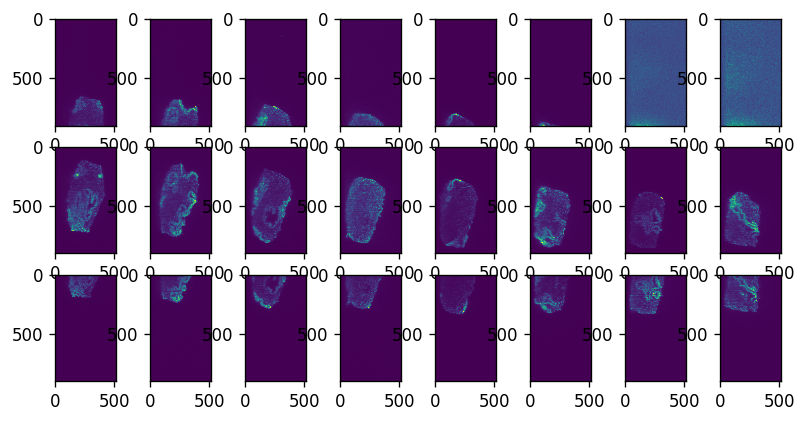

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 4), dpi=120)

for version_index, version_id in enumerate([1, 256, 512, 768, 1024, 1280, 1536, 1800]):
    for stripe_id in range(3):
        ax = fig.add_subplot(3, 8, 1 + version_index + 8 * stripe_id)
        ax.imshow(image_source.get_image(stripe_id, version_id - 1))
        
plt.show()        

In [3]:
from alpenglow.matching_algorithms.fft import FftMatchingAlgorithm
matching_algorithm = FftMatchingAlgorithm(list(range(0, 1800, 50)), [0,])

print(matching_algorithm.match(image_source.get_stripe(0), image_source.get_stripe(1)))

[379 -10]


total time: 111.81311202s
stitching times: [1.1920928955078125e-06, 1.1502771377563477, 1.1742019653320312, 1.101712942123413, 1.111793041229248, 1.090630054473877, 1.1053240299224854]
result_building: 104.71843791s
image fetching time: 47.2106072903


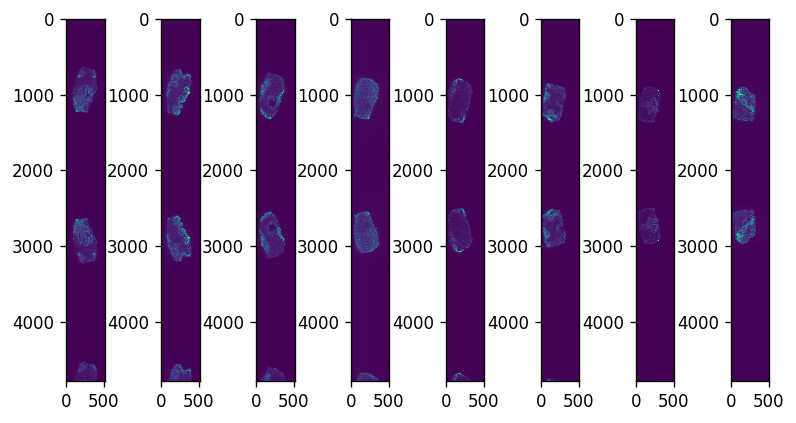

In [4]:
from alpenglow.patchwork_builders.default import PatchworkBuilder
from alpenglow.image_sources.benchmarking import BenchmarkingImageSource

benchmarking_image_source = BenchmarkingImageSource(image_source)
from time import time
start_time=time()

builder = PatchworkBuilder(matching_algorithm)
for stripe_id in range(7):
    builder.stitch(benchmarking_image_source.get_stripe(stripe_id))
    
patchwork = builder.get()

print("total time: {0}s".format(time() - start_time))
stitching_times, result_building_time = builder.benchmark()
print("stitching times: {0}\nresult_building: {1}s".format(stitching_times, result_building_time))
print("image fetching time: {0}".format(benchmarking_image_source.total_fetching_time()))


%matplotlib inline
fig = plt.figure(figsize=(8, 4), dpi=120)
for version_index, version_id in enumerate([1, 256, 512, 768, 1024, 1280, 1536, 1800]):
    ax = fig.add_subplot(1, 8, 1 + version_index)
    ax.imshow(patchwork.get_image(version_id - 1))


(1800, 4786, 512)


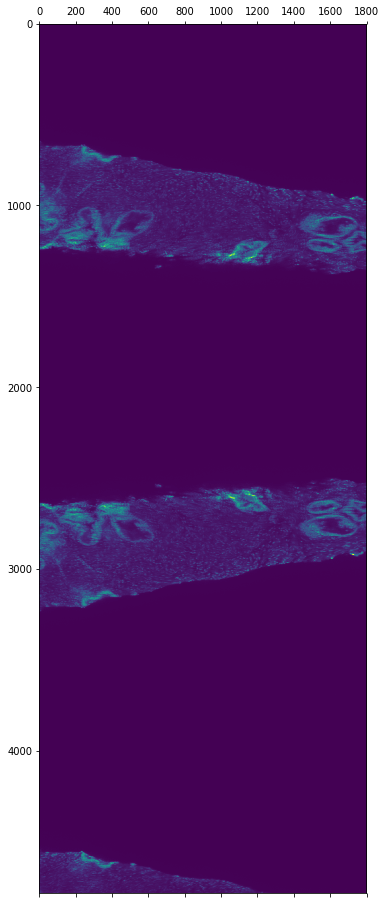

In [5]:
print(patchwork._data.shape)

%matplotlib inline
fig, ax = plt.subplots(figsize=(16, 16))
ax.matshow(patchwork._data[:, :, 256].swapaxes(0, 1))
plt.show()